In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
from birdclef.spark import get_spark
from pyspark.sql import functions as F
from matplotlib import pyplot as plt
from pacmap import PaCMAP
import numpy as np
from pathlib import Path

In [19]:
spark = get_spark(cores=8, memory="20g")

25/04/23 22:15:53 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [20]:
root = Path("~/shared/birdclef/2025").expanduser()
! tree -L 4 {root}

/storage/home/hcoda1/8/amiyaguchi3/shared/birdclef/2025
├── infer-soundscape
│   ├── BirdNET
│   │   └── parts
│   │       ├── embed
│   │       ├── predict
│   │       └── timing
│   └── Perch
│       ├── parts
│       │   ├── embed
│       │   ├── predict
│       │   └── timing
│       └── _SUCCESS
└── infer-soundscape-cpu
    ├── BirdNET
    │   ├── parts
    │   │   ├── embed
    │   │   ├── predict
    │   │   └── timing
    │   └── _SUCCESS
    └── Perch
        ├── parts
        │   ├── embed
        │   ├── predict
        │   └── timing
        └── _SUCCESS

22 directories, 3 files


Let's compare inference time.

In [21]:
def summarize_timings(path):
    print(path)
    df = spark.read.json(path)
    df.agg(F.sum("elapsed") / 3600, F.mean("elapsed"), F.count("elapsed")).show()


summarize_timings(f"{root}/infer-soundscape-cpu/BirdNET/parts/timing")
# summarize_timings(f"{root}/infer-soundscape/BirdNET/parts/timing")
summarize_timings(f"{root}/infer-soundscape-cpu/Perch/parts/timing")
summarize_timings(f"{root}/infer-soundscape/Perch/parts/timing")

/storage/home/hcoda1/8/amiyaguchi3/shared/birdclef/2025/infer-soundscape-cpu/BirdNET/parts/timing
+---------------------+------------------+--------------+
|(sum(elapsed) / 3600)|      avg(elapsed)|count(elapsed)|
+---------------------+------------------+--------------+
|    5.929498420328503|106.73097156591307|           200|
+---------------------+------------------+--------------+

/storage/home/hcoda1/8/amiyaguchi3/shared/birdclef/2025/infer-soundscape-cpu/Perch/parts/timing
+---------------------+-----------------+--------------+
|(sum(elapsed) / 3600)|     avg(elapsed)|count(elapsed)|
+---------------------+-----------------+--------------+
|    53.14476255857981|956.6057260544366|           200|
+---------------------+-----------------+--------------+

/storage/home/hcoda1/8/amiyaguchi3/shared/birdclef/2025/infer-soundscape/Perch/parts/timing
+---------------------+------------------+--------------+
|(sum(elapsed) / 3600)|      avg(elapsed)|count(elapsed)|
+--------------------

Let's look at the embedding spaces and see if they make _any_ sense.

In [22]:
@F.udf("array<float>")
def mean_udf(arr):
    return np.mean(arr, axis=0).tolist()


def read_embeddings(path):
    df = spark.read.parquet(path)
    return df.select(
        *df.columns[:3],
        F.array(*df.columns[3:]).alias("embeddings"),
    )


def average_embeddings(df):
    return (
        df.groupBy("file")
        .agg(mean_udf(F.collect_list("embeddings")).alias("embeddings"))
        .orderBy("file")
    )


birdnet = read_embeddings(f"{root}/infer-soundscape-cpu/BirdNET/parts/embed")
birdnet.printSchema()
birdnet.show(n=3, vertical=True, truncate=100)
avg_birdnet = average_embeddings(birdnet).cache()
avg_birdnet.select("file").distinct().count()
avg_birdnet.select(F.size("embeddings")).distinct().show()

root
 |-- file: string (nullable = true)
 |-- start_time: double (nullable = true)
 |-- end_time: double (nullable = true)
 |-- embeddings: array (nullable = false)
 |    |-- element: float (containsNull = true)

-RECORD 0----------------------------------------------------------------------------------------------------------
 file       | /storage/coda1/p-dsgt_clef2025/0/shared/birdclef/raw/birdclef-2025/train_soundscapes/H02_20230506... 
 start_time | 0.0                                                                                                  
 end_time   | 3.0                                                                                                  
 embeddings | [0.04160746, 0.0, 0.816704, 1.6265234, 0.0, 0.1433202, 0.059183758, 0.073363304, 0.031847376, 0.0... 
-RECORD 1----------------------------------------------------------------------------------------------------------
 file       | /storage/coda1/p-dsgt_clef2025/0/shared/birdclef/raw/birdclef-2025/train_soun

25/04/23 22:15:57 WARN CacheManager: Asked to cache already cached data.


+----------------+
|size(embeddings)|
+----------------+
|            1024|
+----------------+



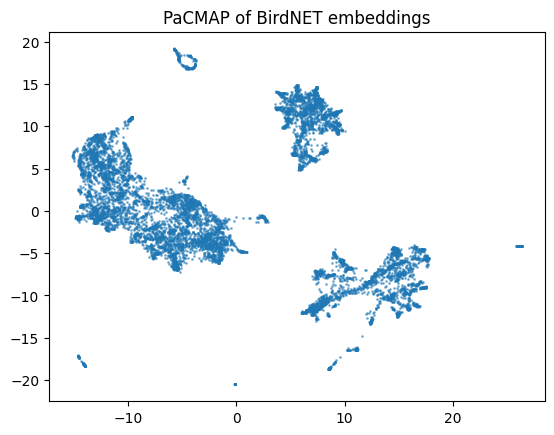

In [23]:
def plot_embeddings(df, title, color=None):
    pdf = df.toPandas()
    X = np.stack(pdf.embeddings.values)
    reducer = PaCMAP(n_components=2)
    g = reducer.fit_transform(X)
    kwargs = {}
    if color is not None:
        kwargs["c"] = color
    plt.scatter(g[:, 0], g[:, 1], s=1, alpha=0.5, **kwargs)
    plt.title(title)
    plt.show()


plot_embeddings(avg_birdnet, "PaCMAP of BirdNET embeddings")

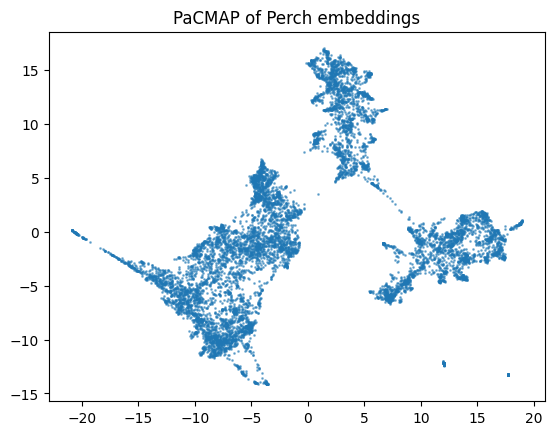

In [24]:
perch = read_embeddings(f"{root}/infer-soundscape-cpu/Perch/parts/embed")
avg_perch = average_embeddings(perch).cache()
plot_embeddings(avg_perch, "PaCMAP of Perch embeddings")

In [25]:
pdf = avg_birdnet.toPandas()
X = np.stack(pdf.embeddings.values)
reducer = PaCMAP(n_components=1)
# color g with dim 1
c_g_d1 = reducer.fit_transform(X)

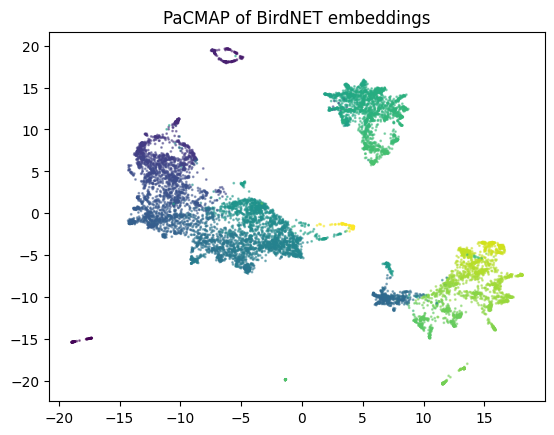

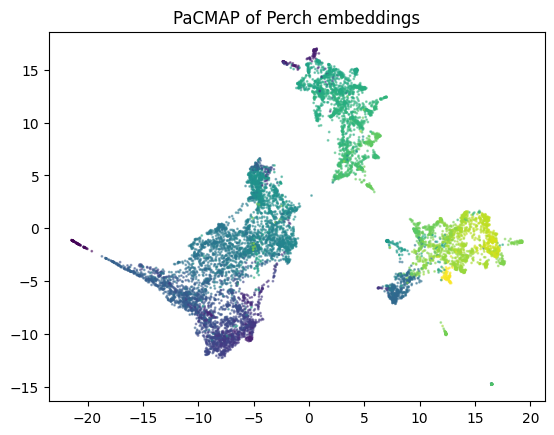

In [26]:
plot_embeddings(avg_birdnet, "PaCMAP of BirdNET embeddings", color=c_g_d1)
plot_embeddings(avg_perch, "PaCMAP of Perch embeddings", color=c_g_d1)

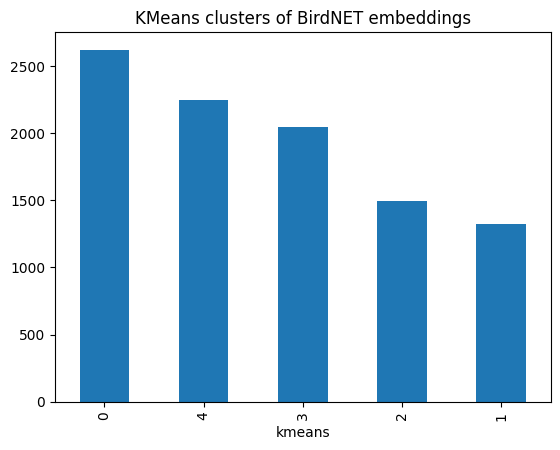

In [27]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=0).fit(X)
pdf["kmeans"] = kmeans.labels_
pdf["kmeans"].value_counts().plot(kind="bar")
plt.title("KMeans clusters of BirdNET embeddings")
plt.show()

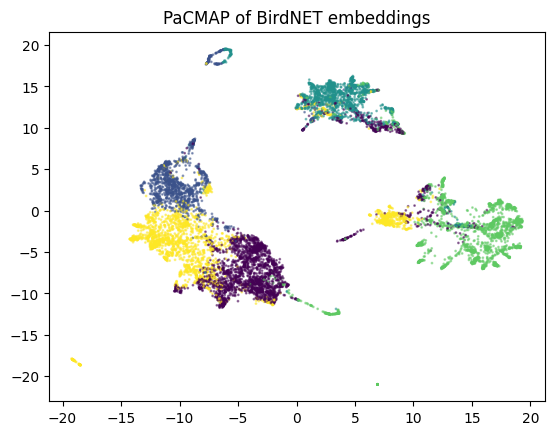

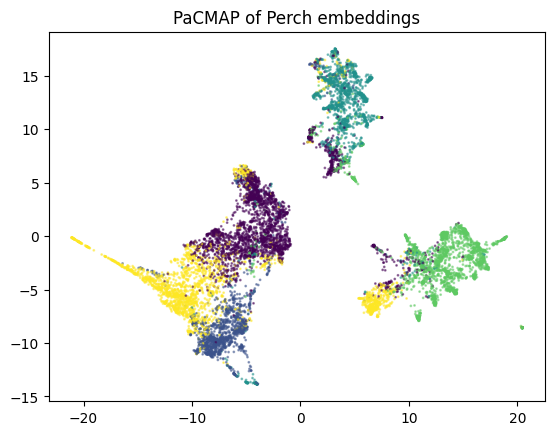

In [28]:
# plot the cluster as a color
plot_embeddings(avg_birdnet, "PaCMAP of BirdNET embeddings", color=pdf["kmeans"])
plot_embeddings(avg_perch, "PaCMAP of Perch embeddings", color=pdf["kmeans"])